# Защита персональных данных клиентов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Импорт" data-toc-modified-id="Импорт-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Для этого нужно разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, и обосновать корректность его работы.

Нужно защитить данные так, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Импорт

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


%matplotlib inline

## Загрузка данных

In [2]:
try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')

Выведем первые 10 строк датафрейма.

In [3]:
data.head(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


Выведем общую информацию о датафрейме.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Данные не содержат пропусков. Типы данных указаны верно, с оговоркой, что признак `Пол` категориальный, остальные численные.

Из контекста задачи очевидно, что **`Страховые выплаты` - целевой признак**.

## Исследовательский анализ
Выведем гистограммы распределений числовых признаков.

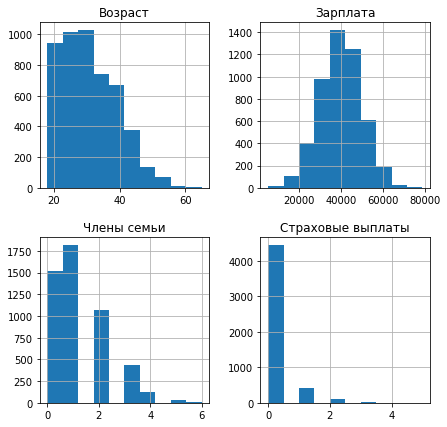

In [5]:
data.drop(columns='Пол').hist(figsize=(7, 7))

plt.show()

Построим диаграммы рассеяния для каждой пары числовых признаков, чтобы оценить наличие корреляции между ними.

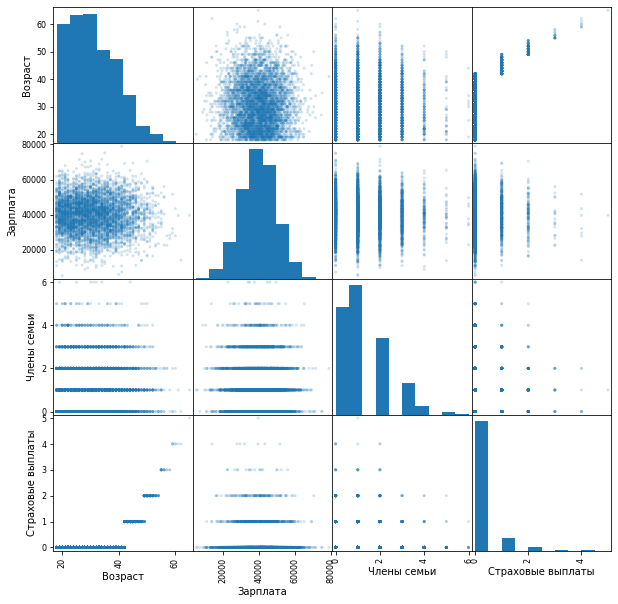

In [6]:
scatter_matrix(data.drop(columns='Пол'), figsize=(10, 10), alpha=0.2)
plt.show()

Похоже, что небольшая корреляция есть между признаком `Возраст` и целевым признаком `Страховые выплаты`. При этом признаки меют разный масштаб, возможно, потребуется стандартизация значенией перед выполнением регрессии.

Набор данных содержит один категориальный признак `Пол`. Проверим различаются ли количества страховых выплат для мужчин и женщин.

In [7]:
data.groupby('Пол')[['Страховые выплаты']].agg(['min', 'mean', 'median', 'max'])

Страховые выплаты                     
                  min      mean median max
Пол                                       
0                   0  0.143313      0   4
1                   0  0.152705      0   5

Похоже, что количество страховых выплат для мужчин и женщин не различается.

Выведем на экран матрицу корреляции, чтобы окончательно убедиться, что корреляция есть только между признаком `Возраст` и целевым признаком `Страховые выплаты`. Будем вычислять коэффициент корреляции Кенделла, так как в наборе данных есть категориальный признак.

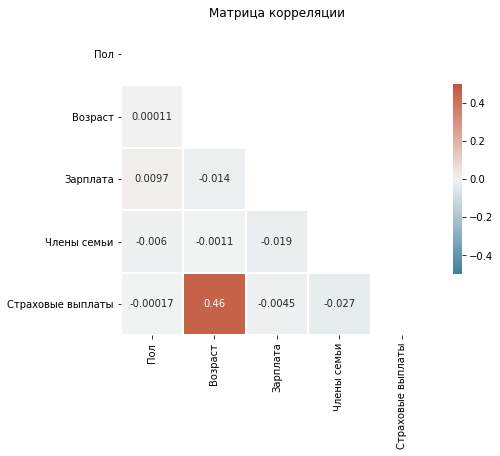

In [8]:
corr = data.corr(method='kendall')

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(7, 7))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            annot=True,
            vmax=0.5,
            vmin=-0.5,
            center=0.0,
            square=True,
            linewidths=1.0,
            cbar_kws={'shrink': 0.5},
            ax=ax
           )

ax.set_title('Матрица корреляции')

plt.show()

Корреляция наблюдается только между целевым признаком `Страховые выплаты` и признаком `Возраст`.

## Подготовка данных
Разделим набор данных на матрицу признаков `X` и целевой вектор `y`.

In [9]:
X = data.drop(columns='Страховые выплаты').to_numpy()
y = data['Страховые выплаты'].to_numpy()

## Умножение матриц

*Изменится ли качество линейной регрессии, если признаки умножить на обратимую матрицу?*

**Ответ:** Не изменится.

**Обоснование:** 

Введём следующие обозначения:

$X = \left(\begin{array}{c}
           1   & x_{01} & x_{02} & ... & x_{0n} \\ 
           1   & x_{11} & x_{12} & ... & x_{1n} \\
           ... & ...    & ...    & ... & ...    \\
           1   & x_{m1} & x_{m2} & ... & x_{mn}
\end{array}\right)$ — матрица признаков;

$y = \left(\begin{array}{c} y_{0} \\ y_{1} \\ ... \\ y_{m} \end{array}\right)$ — вектор целевого признака;

$P = \left(\begin{array}{c}
           1   & p_{01} & p_{02} & ... & p_{0n} \\ 
           1   & p_{11} & p_{12} & ... & p_{1n} \\
           ... & ...    & ...    & ... & ...    \\
           1   & p_{n1} & p_{n2} & ... & p_{nn}
\end{array}\right)$ — обратиая матрица, на которую умножаются признаки;

$w = \left(\begin{array}{c} w_{0} \\ w_{1} \\ ... \\ w_{n} \end{array}\right)$ — вектор весов линейной регрессии.

Предсказания модели линейной регрессии вычисляют по следующей формуле:

$$ \hat{y} = Xw \;.$$

Задача обучения формулируется следующим образом:

$$ w = \arg\min_w MSE(\hat{y}, y) $$

$$ w = \arg\min_w MSE(Xw, y) \;, $$ тогда формула обучения имеет вид выражения

$$ w = (X^T X)^{-1} X^T y $$

Предположим, что, если умножить признаки $X$ на обратимую матрицу $P$, то предсказания модели будут иметь следующий вид: 

$$ \hat{y}^\star = (XP)w^\star \;,\: где $$

$w^\star$ — вектор весов линейной регрессии, выполненной после перемножения признаков $X$ на обратимую матрицу $P$.

Чтобы доказать, что умножение $X$ на $P$ не изменяет качество линейной регрессии, покажем, что $\hat{y}=\hat{y}^\star$.

Cформулируем задачу обучения для $w^\star$

$$ w^\star = \arg\min_{w^\star} MSE(\hat{y}^\star, y) $$

$$ w^\star = \arg\min_{w^\star} MSE((XP)w^\star, y) $$

Формула обучения, если вместо $X$ подставить $XP$, а вместо $w$ подставить $w^\star$ примет следующий вид:

$$ w^\star = ((XP)^T (XP))^{-1} (XP)^T y $$


Воспользуемся свойством ассоциативности умножения матриц и перегруппируем скобки под знаком возведения в степень $-1$:

$$ w^\star = \left(\left((XP)^T X\right) P\right)^{-1} (XP)^T y $$

Раскроем внешние скобки:

$$ w^\star = P^{-1}\left((XP)^T X\right)^{-1} P^T X^T y $$

Раскроем скобку $(XP)^T$:

$$ w^\star = P^{-1}\left(P^T X^T X\right)^{-1} P^T X^T y $$

Сгруппируем $X^T X$ и раскроем скобку $ \left(P^T (X^T X)\right)^{-1} $:

$$ w^\star = P^{-1}\left(X^T X\right)^{-1} \left(P^T\right)^{-1} P^T X^T y $$

Сократим $\left(P^T\right)^{-1}$ и $P^T$:

$$ w^\star = P^{-1}\left(X^T X\right)^{-1} X^T y $$

В правой части равенства выполним замену $(X^T X)^{-1} X^T y$ на $w$:

$$ w^\star = P^{-1} w $$

**Мы нашли связь между параметрами линейной регресси исходной задачи и преобразованной $ w^\star = P^{-1} w $**.

Подставим полученное выражение в формулу предсказаний линейной регрессии преобразованной задачи 
$ \hat{y}^\star = (XP)w^\star $:

$$ \hat{y}^\star = (XP)P^{-1}w $$

Уберём скобки и сократим $P$:

$$ \hat{y}^\star = Xw $$

**Таким образом, мы получили $ \hat{y}^\star = \hat{y} \;, $ что и требовалось доказать.**

## Алгоритм преобразования

**Алгоритм**

Для защиты данных клиентов предложим следующий алгоритм преобразования:
1. Генерируется матрица $P$, заполненная слчайными числами, размерности $n\times n$, где $n$ - равно количеству обучающих признаков.
2. Проверяем обратима ли матрица $P$, если она оказалась необратимой (вероятность такого события мала) повторяем шаг 1.
2. Матрица признаков $X$ умножается на полученную матрицу $P$, вектор целевого признака $y$ остаётся без изменеий.
3. После этого можно приступить к линейной регрессии, используя в качестве матрицы признаков $X^\star = XP$, а $y$ - в качестве вектора целевого признака.

**Обоснование**

В разделе 5, мы показали, что умножение матрицы признаков на обратимую матрицу $P$ не влияет на результат линейной регрессии, то есть $ \hat{y}^\star = \hat{y} $. Изменяются только коэффициенты линейной регрессии, при этом коэффициенты линейной регрессии в исходной и преобразованной задачах связаны следующим выражением: $ w^\star = P^{-1} w $.

Считается, что вероятность того, что случайно сгенерированная матрица $P$ окажется необратимой мала. Проверка $P$ на обратимость полностью исключает такую ситуацию,

## Проверка алгоритма

Проверим, что качество линейной регрессии из `sklearn` не отличается до и после преобразования.

Напишем трансформер для `sklearn`, который будет вычислять $X^\star = XP$.

In [10]:
class DataProtector(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self._p_matrix = np.random.normal(size=([X.shape[1]] * 2))
        
        while True:
            try:
                inv_p_matrix = np.linalg.inv(self._p_matrix)
            except np.linalg.LinAlgError:
                pass
            else:
                return self
            
    def transform(self, X, y=None):
        return X @ self._p_matrix

Напишем пайплайн, осуществляющий преобразование данных и линейную регрессию.

In [11]:
pipe = Pipeline([
    ('data_protector', DataProtector()),
    ('scaler', StandardScaler()),
    ('lin_regr', LinearRegression())
])

Проверим значение метрики *R2* для разработанной модели.

In [12]:
print(f'Значение метрики R2 для модели с преобразоваением для защиты данных: {pipe.fit(X, y).score(X, y):.4f}')

Значение метрики R2 для модели с преобразоваением для защиты данных: 0.4249


Теперь, уберём из конвейра шаг с преобразованием для защиты данных и повторно оценим метрику *R2*.

In [13]:
pipe.set_params(data_protector='passthrough')
print(f'Значение метрики R2 для модели без дополнительных преобразований: {pipe.fit(X, y).score(X, y):.4f}')

Значение метрики R2 для модели без дополнительных преобразований: 0.4249


В обоих случаях метрики совпадают, то есть умножение признаков на обратимую матрицу не влияет на качество линейной регрессии.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные загружены
- [x]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [x]  Указан правильный вариант ответа
    - [x]  Вариант обоснован
- [x]  Выполнен шаг 3: предложен алгоритм преобразования
    - [x]  Алгоритм описан
    - [x]  Алгоритм обоснован
- [x]  Выполнен шаг 4: алгоритм проверен
    - [x]  Алгоритм реализован
    - [x]  Проведено сравнение качества моделей до и после преобразования